# Movie Recommendation System with MovieLens

**Problem Statement:** Recommender systems predict a user's preference for items they haven't seen yet. In this project, we build a movie recommendation engine using the MovieLens dataset, exploring Collaborative Filtering, Content-Based Filtering, and Matrix Factorization (SVD).

The following code is provided to help you get started. For neural networks approaches, we recommend using a GPU to train.

## 1. Install and Import Dependencies

In [1]:
# Install additional packages if needed
# !pip install scikit-surprise pandas matplotlib seaborn

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

pd.set_option('display.max_columns', None)
print("Dependencies loaded!")

Dependencies loaded!


## 2. Download the MovieLens Dataset

We use the **MovieLens 100k** dataset.

The following code will create a data folder with the MovieLens dataset inside. You only need to run the cell block once.

In [2]:
DATA_DIR = './data/movielens'
os.makedirs(DATA_DIR, exist_ok=True)

# MovieLens 100K (small, good for development)
ML_100K_URL = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

dataset_name = 'ml-latest-small'

if not os.path.exists(os.path.join(DATA_DIR, dataset_name)):
    print(f"Downloading MovieLens ({dataset_name})...")
    !wget -q {ML_100K_URL} -O {DATA_DIR}/movielens.zip
    !unzip -q {DATA_DIR}/movielens.zip -d {DATA_DIR}
    !rm {DATA_DIR}/movielens.zip
    print("Download complete!")
else:
    print("Dataset already exists.")

dataset_path = os.path.join(DATA_DIR, dataset_name)
print(f"\nDataset files: {os.listdir(dataset_path)}")

Download complete!

Dataset files: ['tags.csv', 'movies.csv', 'ratings.csv', 'README.txt', 'links.csv']


## 3. Load and Explore the Data

In [3]:
# Load CSV files
ratings_df = pd.read_csv(os.path.join(dataset_path, 'ratings.csv'))
movies_df = pd.read_csv(os.path.join(dataset_path, 'movies.csv'))
tags_df = pd.read_csv(os.path.join(dataset_path, 'tags.csv'))

print("=== Ratings ===")
print(f"Shape: {ratings_df.shape}")
print(ratings_df.head())
print(f"\n=== Movies ===")
print(f"Shape: {movies_df.shape}")
print(movies_df.head())
print(f"\n=== Tags ===")
print(f"Shape: {tags_df.shape}")
print(tags_df.head())

=== Ratings ===
Shape: (100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

=== Movies ===
Shape: (9742, 3)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

=== Tags ===
Shape: (3683, 4)
   userId  movieId              tag   timestamp
0       2    60756            

In [4]:
# Basic statistics
n_users = ratings_df['userId'].nunique()
n_movies = ratings_df['movieId'].nunique()
n_ratings = len(ratings_df)
sparsity = 1 - (n_ratings / (n_users * n_movies))

print(f"Number of users: {n_users:,}")
print(f"Number of movies: {n_movies:,}")
print(f"Number of ratings: {n_ratings:,}")
print(f"Average ratings per user: {n_ratings / n_users:.1f}")
print(f"Average ratings per movie: {n_ratings / n_movies:.1f}")
print(f"Matrix sparsity: {sparsity:.4%}")
print(f"\nRating distribution:")
print(ratings_df['rating'].describe())

Number of users: 610
Number of movies: 9,724
Number of ratings: 100,836
Average ratings per user: 165.3
Average ratings per movie: 10.4
Matrix sparsity: 98.3000%

Rating distribution:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


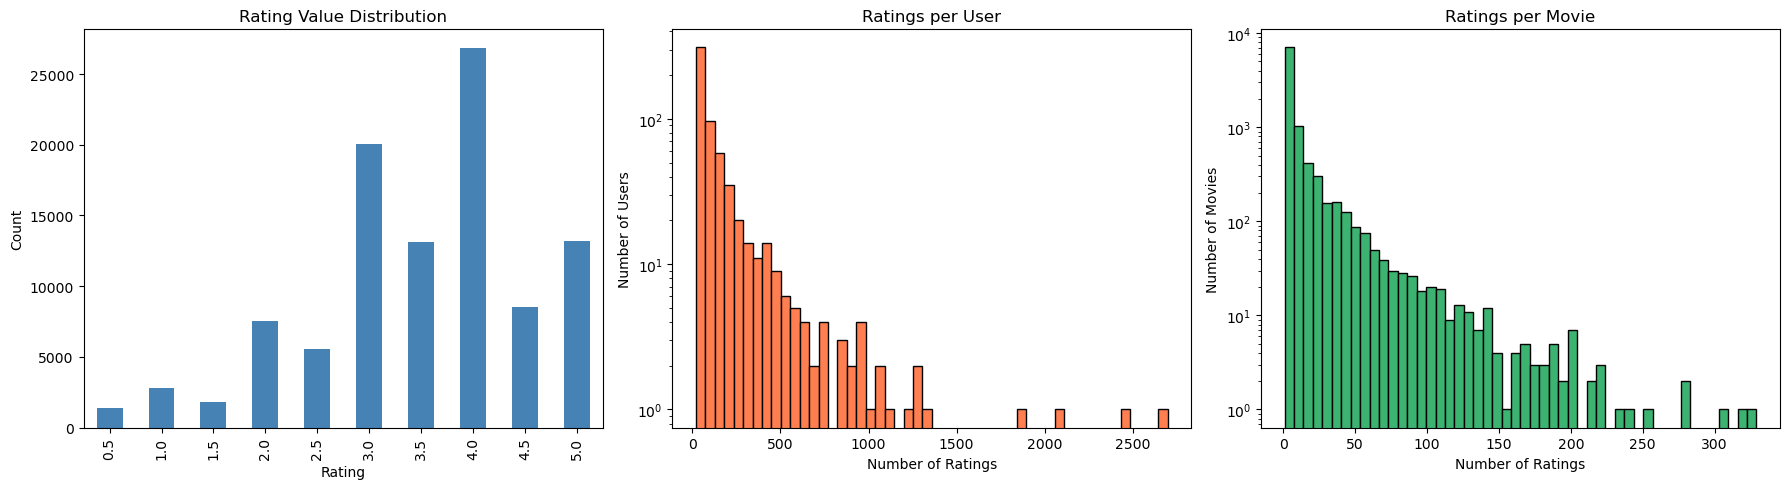

In [5]:
# Visualize rating distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rating value distribution
ratings_df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Rating Value Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Ratings per user
user_counts = ratings_df.groupby('userId').size()
axes[1].hist(user_counts, bins=50, color='coral', edgecolor='black')
axes[1].set_title('Ratings per User')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Users')
axes[1].set_yscale('log')

# Ratings per movie
movie_counts = ratings_df.groupby('movieId').size()
axes[2].hist(movie_counts, bins=50, color='mediumseagreen', edgecolor='black')
axes[2].set_title('Ratings per Movie')
axes[2].set_xlabel('Number of Ratings')
axes[2].set_ylabel('Number of Movies')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

In [6]:
# Most popular movies
movie_stats = ratings_df.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

movie_stats = movie_stats.merge(movies_df[['movieId', 'title', 'genres']], on='movieId')

# Top 10 most rated movies
print("Top 10 Most Rated Movies:")
top_movies = movie_stats.nlargest(10, 'num_ratings')[['title', 'num_ratings', 'avg_rating', 'genres']]
print(top_movies.to_string(index=False))

Top 10 Most Rated Movies:
                                    title  num_ratings  avg_rating                           genres
                      Forrest Gump (1994)          329    4.164134         Comedy|Drama|Romance|War
         Shawshank Redemption, The (1994)          317    4.429022                      Crime|Drama
                      Pulp Fiction (1994)          307    4.197068      Comedy|Crime|Drama|Thriller
         Silence of the Lambs, The (1991)          279    4.161290            Crime|Horror|Thriller
                       Matrix, The (1999)          278    4.192446           Action|Sci-Fi|Thriller
Star Wars: Episode IV - A New Hope (1977)          251    4.231076          Action|Adventure|Sci-Fi
                     Jurassic Park (1993)          238    3.750000 Action|Adventure|Sci-Fi|Thriller
                        Braveheart (1995)          237    4.031646                 Action|Drama|War
        Terminator 2: Judgment Day (1991)          224    3.970982        

## 4. Parse Genres (for Content-Based Filtering)

In [7]:
# Parse genres into a multi-hot encoded DataFrame
all_genres = set()
for genres_str in movies_df['genres']:
    if genres_str != '(no genres listed)':
        all_genres.update(genres_str.split('|'))

all_genres = sorted(all_genres)
print(f"All genres ({len(all_genres)}): {all_genres}")

# Create genre feature matrix
genre_matrix = pd.DataFrame(0, index=movies_df['movieId'], columns=all_genres)
for _, row in movies_df.iterrows():
    if row['genres'] != '(no genres listed)':
        for genre in row['genres'].split('|'):
            genre_matrix.loc[row['movieId'], genre] = 1

print(f"\nGenre feature matrix shape: {genre_matrix.shape}")
print(genre_matrix.head())

All genres (19): ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Genre feature matrix shape: (9742, 19)
         Action  Adventure  Animation  Children  Comedy  Crime  Documentary  \
movieId                                                                       
1             0          1          1         1       1      0            0   
2             0          1          0         1       0      0            0   
3             0          0          0         0       1      0            0   
4             0          0          0         0       1      0            0   
5             0          0          0         0       1      0            0   

         Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  Romance  \
movieId                                                                       
1            0        1 

## 5. Train/Test Split

In [8]:
# Split ratings into train and test sets
# Strategy: For each user, hold out 20% of their ratings for testing

train_data = []
test_data = []

for user_id, user_ratings in ratings_df.groupby('userId'):
    user_train, user_test = train_test_split(
        user_ratings, test_size=0.2, random_state=42
    )
    train_data.append(user_train)
    test_data.append(user_test)

train_df = pd.concat(train_data).reset_index(drop=True)
test_df = pd.concat(test_data).reset_index(drop=True)

print(f"Training ratings: {len(train_df):,}")
print(f"Test ratings: {len(test_df):,}")
print(f"Train users: {train_df['userId'].nunique()}, Test users: {test_df['userId'].nunique()}")

Training ratings: 80,419
Test ratings: 20,417
Train users: 610, Test users: 610


In [ ]:
#TODO: Your code here